### Sensitivity Analysis
Machine learning model performance often improves with dataset size for predictive modeling.

This depends on the specific datasets and on the choice of model, although it often means that using more data can result in better performance and that discoveries made using smaller datasets to estimate model performance often scale to using larger datasets.

The problem is the relationship is unknown for a given dataset and model, and may not exist for some datasets and models. Additionally, if such a relationship does exist, there may be a point or points of diminishing returns where adding more data may not improve model performance or where datasets are too small to effectively capture the capability of a model at a larger scale.

These issues can be addressed by performing a sensitivity analysis to quantify the relationship between dataset size and model performance. Once calculated, we can interpret the results of the analysis and make decisions about how much data is enough, and how small a dataset may be to effectively estimate performance on larger datasets.

The method of this Notebook is based on this tutorial: https://machinelearningmastery.com/sensitivity-analysis-of-dataset-size-vs-model-performance/

### Methodology
In this experiment, we will use the model of Fine-tuning bert classifier in 1.3.1-causal-relation-presence-bert-for-sequence-classification. The model architecture of Fine-Tuning Bert is as follows, and this figure is referenced from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/.
<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" style="width:600px;height:500px">
Our first step is to tokenize the paragraphs -- break them up into word and subwords in the format BERT is comfortable with. This process contains adding [CLS] and [SEP] tokens as well as substituting tokens with their IDs (tokens2IDs).

After tokenization, tokenized is a list of paragraphs -- each paragraph is represented as a list of tokens. And we want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

However, if we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. Finally, we will re-train the bert model then validate on eval_set, the corresponding visualization will be implemented as well.

### Experiment structure

#### Sensitivity Analysis
In an attempt to varify whether the model will better performance when increasing the dataset, we designed the Sensitivity Analysis. To do this, we first split the whole dataset to training, validation, and test set to ensure our validation won't be unfair. After that, we read training set in order according to the n_sample hyper-parameter, that is: read n data points as our experiment set from the first data point in the training set.

#### Over-sampling
Since our data is imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. To keep consistency, we will only do over-sampling for those data points that after the n_sample filter.

#### Evaluation
Since our data is imbalanced, we determined using Macro F1 score as our evaluation metrics, it computes F1 scores for each label, and returns the average without considering the proportion for each label in the dataset.


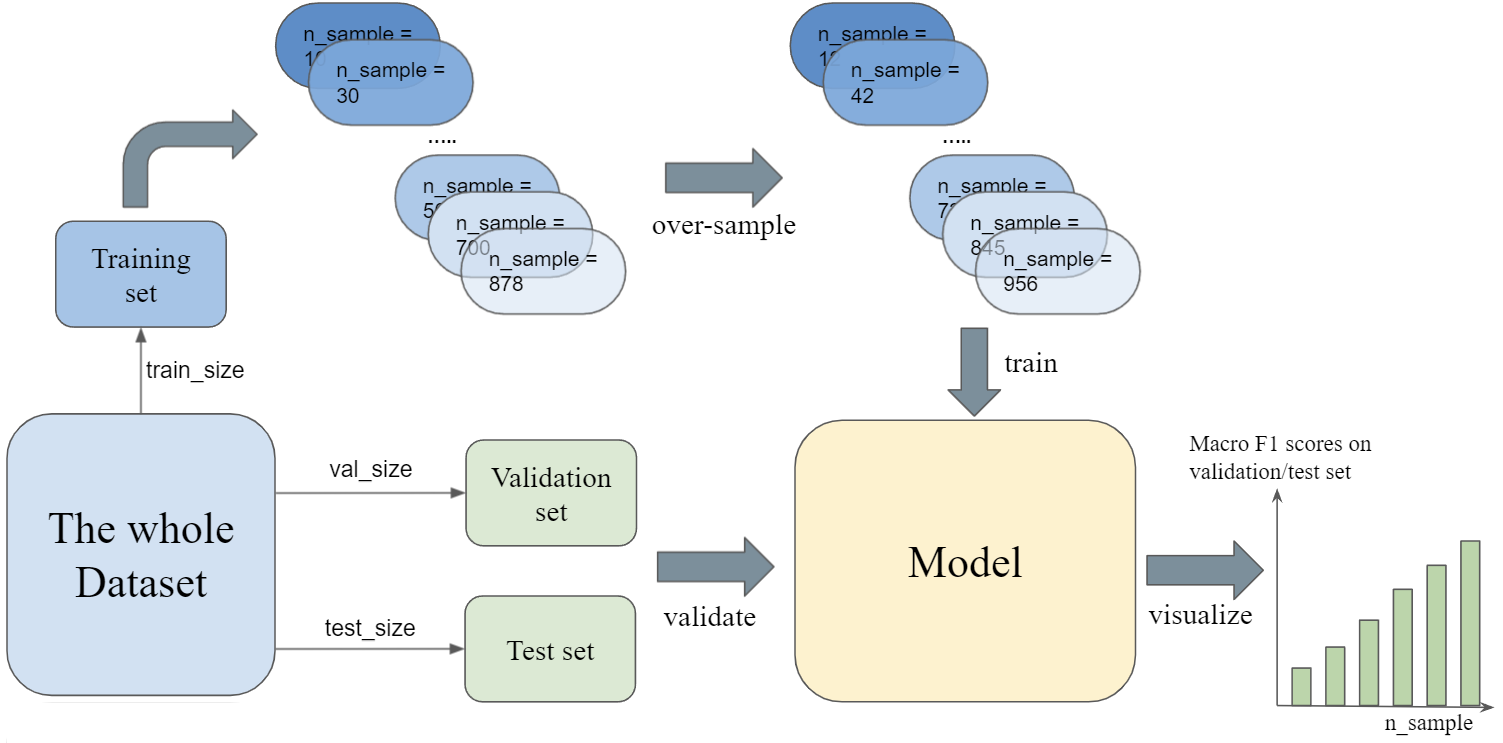

### I. Data preparation

In [1]:
cd ..

In [2]:
import os
from src.data.make_dataset import read_data_file
from src.data.make_dataset import make_dataset
import fasttext
from langdetect import detect
from nltk.tokenize import word_tokenize
import numpy as np
import re
import random
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.utils import shuffle,resample
from sklearn.model_selection import KFold
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
import itertools
from collections import OrderedDict,defaultdict 
import datetime
from IPython.display import clear_output
import pprint
from sklearn.metrics import classification_report,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.model_selection import KFold,train_test_split
from sklearn.utils import shuffle,resample
import time
import torch
import warnings
from transformers import BertTokenizer,RobertaTokenizer,BertForSequenceClassification,get_linear_schedule_with_warmup,AdamW, BertConfig, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


In [3]:
assert os.path.isdir("data/annotations"), 'The directory "data/annotations" does not exist!'
assert os.path.isdir("data/documents"), 'The directory "data/documents" does not exist!'
map_contents = read_data_file("data/annotations/Map_Contents-20200726.csv")
speech_contents = read_data_file("data/annotations/Speech_Contents-20210520.txt")
speeches = read_data_file("data/annotations/Speeches-20210520.txt")

In [4]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: data\documents\2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: data\documents\2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: data\documents\2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: data\documents\2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: data\documents\2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: data\documents\2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: data\documents\2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: data\documents\2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: data\documents\2012-07-26 Barroso European Commission.txt
skipping file in language fr: data\documents\2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: data\documents\2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: data\documents\2013-

### II.helper functions

In [5]:
def get_device():
    if torch.cuda.is_available():

        # Tell PyTorch to use the GPU.
        device = torch.device("cuda")

        print('There are %d GPU(s) available.' % torch.cuda.device_count())

        print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

def over_sampling(df,seed_val):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    if len(df_false)>0:
        print('Now all training data is true class, we will not do oversampling for this turn.')
    
        #Upsampling, for the class with less data, copy some data 
        df_false_upsampled = resample(df_false,random_state=seed_val,n_samples=len(df_true),replace=True)
        df_upsampled = pd.concat([df_false_upsampled,df_true])
        df_upsampled = shuffle(df_upsampled)
        
        print('\nWe totally have {} training data after oversampling.'.format(len(df_upsampled)))
        return df_upsampled
    else:
        return df

In [6]:
def transform_df(df):
    # transform label to int
    df.loc[df['y'] == 'True', 'y'] = 1
    if len(df[df['y'] == False]) >0:
        df.loc[df['y'] == 'False', 'y'] = 0
    df.y = df.y.astype(int)
    return df

def train_val_test(train_ratio, validation_ratio, test_ratio, X, y,seed_val):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """

    df = pd.DataFrame({'X': pd.Series(X), 'y': pd.Series(y)})


    df_train, df_test = train_test_split(df, test_size=1 - train_ratio, random_state=seed_val)
    df_val, df_test = train_test_split(df_test, test_size=test_ratio / (test_ratio + validation_ratio),
                                       random_state=seed_val)

    X_train, y_train = df_train['X'], df_train['y']
    X_val, y_val = df_val['X'], df_val['y']
    X_test, y_test = df_test['X'], df_test['y']

    print('[X training set shape, X validation set shape, X test set shape]:', y_train.shape, y_val.shape, y_test.shape)

    df_train = pd.DataFrame({'X': pd.Series(X_train), 'y': pd.Series(y_train)})
    df_train = transform_df(df_train)

    # transform testset to right form
    df_val = pd.DataFrame({'X': pd.Series(X_val), 'y': pd.Series(y_val)})
    df_val = transform_df(df_val)

    df_test = pd.DataFrame({'X': pd.Series(X_test), 'y': pd.Series(y_test)})
    df_test = transform_df(df_test)

    return df_train, df_val, df_test

In [7]:
# get divice info for torch
device = get_device()

# set seed for random, numpy, torch
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
if str(device) == 'cuda':
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
else:
    torch.manual_seed(seed_val)

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070 SUPER


### II. Transformer

In [8]:
def tokenize_process(df,tokenizer,max_length):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    
    sentences = df.X.values
    labels = df.y.values
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,   # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    # Print sentence 0, now as a list of IDs.
    #print('Check the original paragraph and converted paragrapg: ')
    #print('Original: ', sentences[1])
    #print('Token IDs:', input_ids[1])
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred

In [9]:
def Training_and_evaluating(model,train_dataloader,validation_dataloader,optimizer,epochs,scheduler,total_steps):
    print('\nTraining and evaluating the model.')
    
    #store a number of quantities such as training and validation loss,validation accuracy, and timings.
    training_stats = []
    total_t0 = time.time()
    
    #store prediction and true labels
    train_logits = []
    train_label = []
    best_loss = 1.0
    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
    
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
    
            model.zero_grad()        
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            
            logits_ = logits.detach().cpu().numpy()
            label_ids_ = b_labels.to('cpu').numpy()
            
            #store prediction for the last epoch
            if epoch_i == epochs-1:
                train_logits.extend(logits_)
                train_label.extend(label_ids_)
            total_train_loss += loss.item()
    
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.Update the learning rate.
            optimizer.step()
        
        #Update scheduler(lr decay) every epoch
        lr_stat_opt = optimizer.param_groups[0]["lr"] #or lr_stat_scheduler = scheduler.get_last_lr()[0]
        print('current lr is:',lr_stat_opt)
        if scheduler:
            scheduler.step()

    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
    
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
    
        print("")
        print("Running Validation...")
        eval_pred = []
        eval_label = []
        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
            # `batch` contains three pytorch tensors: [0]: input ids; [1]: attention masks; [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            #total_eval_accuracy += flat_accuracy(logits, label_ids)
            eval_pred.extend(logits)
            eval_label.extend(label_ids)
        

        eval_pred = convert_logits_tolabel(eval_pred)
        f1_val = f1_score(eval_label,eval_pred,average='macro')
        
        
        # Report the final accuracy for this validation run.
        #avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Macro F1 score: {0:.2f}".format(f1_val))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
            
        
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Macro F1.': f1_val,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    print("")
    print("Training complete!")
    
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    pd.set_option('precision', 2)
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)
    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')
    
    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    
    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    epoch_list = [i+1 for i in range(epochs)]
    plt.xticks(epoch_list)
    
    plt.show()
    
    
    train_pred = convert_logits_tolabel(train_logits)
    
    return train_pred,eval_pred,train_label,eval_label

def get_prediction(df_test,model,batch_size,max_length,model_name):
    if model_name=='bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name=='roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')

    test_dataset = tokenize_process(df_test,tokenizer,max_length)
    test_dataloader = DataLoader(test_dataset,sampler = SequentialSampler(test_dataset),batch_size = batch_size)
    
    test_logits = []
    test_label = []
    model.eval()
    
    for batch in test_dataloader:
        """
        Unpack this training batch from our dataloader.
        `batch` contains three pytorch tensors: [0]: input ids; [1]: attention masks; [2]: labels 
        """
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            test_logits.extend(logits)
            test_label.extend(label_ids)
            
    def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred
    
    test_logits = convert_logits_tolabel(test_logits)
            
    return test_logits,test_label

In [10]:
def transformer_cls(df_train,df_val,
             epochs = 10,
             batch_size =16,
             max_length=128,
             model_name='roberta',
             lr = 5e-5,
             weight_decay = 1e-2,
             freeze_layer_count=1,
             scheduler_type='step',
             decayRate=0.75):
    
    print('\n======================Doing Bert classification task======================')
    
    """
    step1: Tokenization
    """
    #print('Do step1: Tokenization\n')
    if model_name=='bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name=='roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')
    
    train_dataset = tokenize_process(df_train,tokenizer,max_length)
    val_dataset = tokenize_process(df_val,tokenizer,max_length)
    
    """
    step2: create dataloader for both training and eval set
    """
    
    batch_size = batch_size
    
    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset), batch_size = batch_size)
    
    # For validation and test the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)
    
    """
    step3: load bert model
    """
    #print('Do step3: load bert model\n')
    model,optimizer,scheduler,total_steps = model_and_helper(epochs,train_dataloader,model_name,freeze_layer_count,lr,weight_decay,scheduler_type,decayRate)
    
    """
    step4: Training and evaluating
    """
    #print('Do step4: Training and evaluating\n')
    train_pred,eval_pred,train_label,eval_label = Training_and_evaluating(model,train_dataloader,validation_dataloader,optimizer,epochs,scheduler,total_steps)
    
    
    return train_pred,eval_pred,train_label,eval_label

In [11]:
def model_and_helper(epochs,train_dataloader,
                     model_name='roberta',
                     freeze_layer_count=1,
                     lr = 5e-5,
                     weight_decay = 1e-2,
                     scheduler_type='linear',
                     decayRate=0.75):
    
    if model_name == 'bert':
        print('\nLoading bert model.')
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",  num_labels = 2,  output_attentions = False, output_hidden_states = False,  return_dict = False)
        
        
    elif model_name == 'roberta':
        model = RobertaForSequenceClassification.from_pretrained(
            'roberta-base', num_labels = 2, output_attentions = False, output_hidden_states = False, return_dict = False)
        
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')
        
    
    
    # Assign GPU if you have
    if str(device)=='cuda':
        model.cuda()
    else:
        pass
    
    # We freeze here the embeddings of the model
    if freeze_layer_count:
        if model_name == 'bert':
            for param in model.bert.embeddings.parameters():
                param.requires_grad = False
    
            if freeze_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in model.bert.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False
                        
        if model_name == 'roberta':
            for param in model.roberta.embeddings.parameters():
                param.requires_grad = False
    
            if freeze_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in model.roberta.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False
            
        
    
    # Note: AdamW is a class from the huggingface library (as opposed to pytorch), the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr = lr, 
                      eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                      weight_decay = weight_decay 
                    )
    
    epochs = epochs
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs
    
    # set learning rate decay
    if scheduler_type=='linear': 
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value
                                                num_training_steps = total_steps)
    elif scheduler_type=='step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decayRate)
        
    elif scheduler_type=='exponential':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
        
    elif scheduler_type=='none':
        scheduler = None
    
    else:
        raise SystemExit('Invalid scheduler_type, it could only be one of [linear, step, exponential,none] ')
    

    return model,optimizer,scheduler,total_steps

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
def evaluate_result(training_pred,training_true,test_pred_all,test_true_all):
    
    
    def flatten(t):
        return [item for sublist in t for item in sublist]
    
    test_true_all = flatten(test_true_all)
    test_pred_all = flatten(test_pred_all)
    training_true = flatten(training_true)
    training_pred = flatten(training_pred)
    
    
    f1_train = f1_score(training_true, training_pred,average='macro')
    f1_test = f1_score(test_pred_all,test_true_all,average='macro')
    precision_train = precision_score(training_true, training_pred,average='macro')
    precision_test = precision_score(test_pred_all, test_true_all,average='macro')
    recall_train = recall_score(training_true, training_pred,average='macro')
    recall_test = recall_score(test_pred_all, test_true_all,average='macro')

    target_names = ['class 0', 'class 1']
    #For evaluation data
    print('classification report on test set is:\n')
    clas_reprt_eval = classification_report(test_pred_all, test_true_all, target_names=target_names)
    print(clas_reprt_eval)
    
    print('confusion matrix on test set is:\n')
    cm_eval = confusion_matrix(test_pred_all, test_true_all)
    plot_confusion_matrix(cm_eval, ['No causal relation', 'Has causal relation'], normalize=False)
    
    return f1_train,f1_test,precision_train,precision_test,recall_train,recall_test

In [13]:
def sensitivity_analysis(X,y,args,n_samples):
    
    
    result_dict = defaultdict(dict)
    
    #do sensitivity analysis according to the seeting of n_samples
    for n in n_samples:
        args['n_sample'] = n
    
        df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
        print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
        df = df.dropna()
        print('na data dropped')
        
        kf = KFold(n_splits=5,random_state=seed_val, shuffle =True)
        kf.get_n_splits(df)
        
        training_pred = []
        training_true = []
        test_pred_all = []
        test_true_all = []
        
        k = 0
        
        for train_index, test_index in kf.split(df):
            
            print('--------------------------------------------------------Now is {} fold--------------------------------------------------------'.format(k))
            
            X_train, X_test = df['X'][train_index], df['X'][test_index]
            y_train, y_test = df['y'][train_index], df['y'][test_index]
            
            print('[X training set shape, X test set shape]:',X_train.shape,X_test.shape)
            
            X_train = X_train[:args['n_sample']]
            y_train = y_train[:args['n_sample']]
            
            print('After selecting n_sample training data, now [X training set shape, X test set shape] is:',X_train.shape,X_test.shape)
            
            
            # over-sample the Training set, then transform them to right form
            df_train = pd.DataFrame({'X':pd.Series(X_train),'y':pd.Series(y_train)})
            df_train_upsampled = over_sampling(df_train,seed_val)
            df_train_upsampled = transform_df(df_train_upsampled)
            
            # transform testset to right form
            df_test = pd.DataFrame({'X':pd.Series(X_test),'y':pd.Series(y_test)})
            df_test = transform_df(df_test)
            
            print('[X over-sampled training set shape, X over-sampled test set shape]:',df_train_upsampled.shape, df_test.shape)
    
            train_pred,test_pred,train_label,test_true = transformer_cls(df_train_upsampled,df_test,
                                                                              epochs = args['epochs'],
                                                                              batch_size =args['batch_size'],
                                                                              max_length=args['max_length'],
                                                                              model_name=args['model_name'],
                                                                              lr = args['lr'],
                                                                              weight_decay = args['weight_decay'],
                                                                              freeze_layer_count=args['freeze_layer_count'],
                                                                              scheduler_type=args['scheduler_type'],
                                                                              decayRate=args['decayRate'])
            
            torch.cuda.empty_cache()
            
            training_pred.append(train_pred)
            training_true.append(train_label)
            test_pred_all.append(test_pred)
            test_true_all.append(test_true)
            
        
            k+=1
            
        
        
        # generate confusion matrix and classification report
        f1_train,f1_test,precision_train,precision_test,recall_train,recall_test = evaluate_result(training_pred,training_true,test_pred_all,test_true_all)
    
        result_dict[args['n_sample']]['f1_train'] = f1_train
        result_dict[args['n_sample']]['f1_test'] = f1_test
        result_dict[args['n_sample']]['precision_train'] = precision_train
        result_dict[args['n_sample']]['precision_test'] = precision_test
        result_dict[args['n_sample']]['recall_train'] = recall_train
        result_dict[args['n_sample']]['recall_test'] = recall_test
        
        
        #clear output if you want
        #clear_output(wait=True)
    return result_dict


In [14]:
n_samples = [10, 30, 50, 100, 300, 500, 700, 878]
best_args = {
    'n_sample':  None,
    'epochs': 14,
    'batch_size': 20,
    'train_ratio': 0.75,
    'validation_ratio': 0.15,
    'test_ratio': 0.10,
    'max_length': 128,
    'model_name': 'roberta',
    'lr': 1e-05,
    'weight_decay': 0.05,
     'freeze_layer_count': 6,
    'scheduler_type': 'step',
    'decayRate':0.75
    }

In [15]:
best_args

{'n_sample': None,
 'epochs': 14,
 'batch_size': 20,
 'train_ratio': 0.75,
 'validation_ratio': 0.15,
 'test_ratio': 0.1,
 'max_length': 128,
 'model_name': 'roberta',
 'lr': 1e-05,
 'weight_decay': 0.05,
 'freeze_layer_count': 6,
 'scheduler_type': 'step',
 'decayRate': 0.75}

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (10,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 18 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (18, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 5 / 

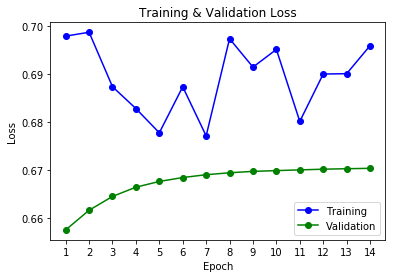

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (10,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 18 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (18, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.71
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 5 / 

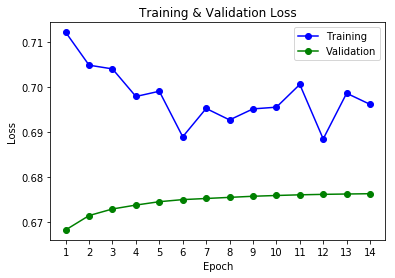

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (10,) (176,)
[X over-sampled training set shape, X over-sampled test set shape]: (10, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.58
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.55
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.54
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.53
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 5 / 

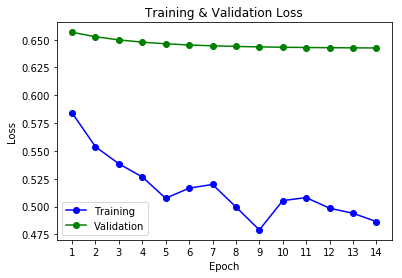

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (10,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 18 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (18, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 5 / 

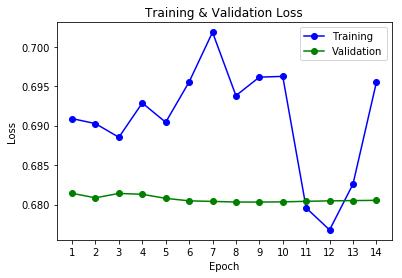

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (10,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 18 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (18, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.71
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 5 / 

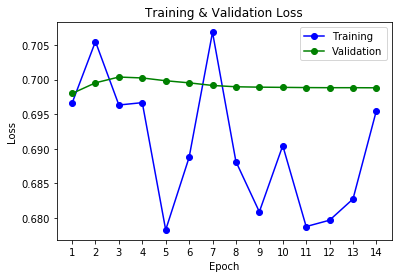

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.21      0.29      0.24       175
     class 1       0.80      0.73      0.77       703

    accuracy                           0.64       878
   macro avg       0.51      0.51      0.51       878
weighted avg       0.69      0.64      0.66       878

confusion matrix on test set is:



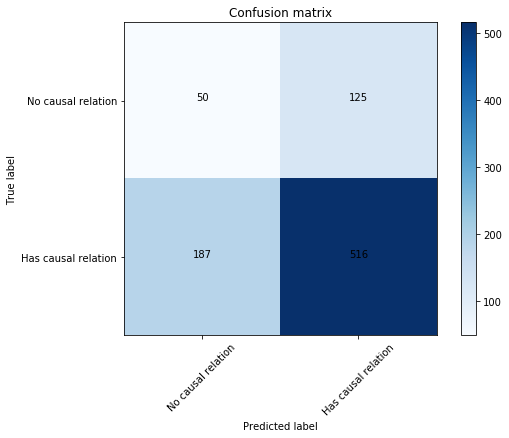

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (30,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 40 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (40, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.19
  Validation Loss: 0.74
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.19
  Validation Loss: 0.73
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.19
  Validation Loss: 0.73
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.19
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 5 / 

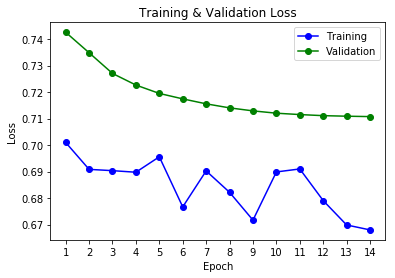

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (30,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 40 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (40, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 5 / 

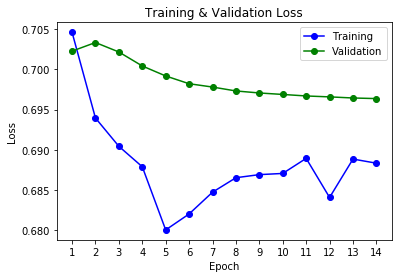

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (30,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 46 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (46, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.24
  Validation Loss: 0.74
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.72
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.24
  Validation Loss: 0.73
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.24
  Validation Loss: 0.73
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.71
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.24
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 5 / 

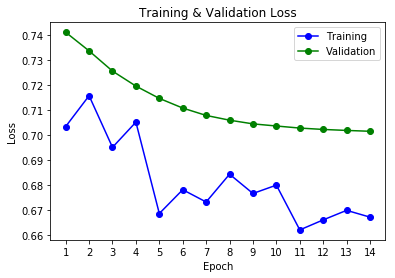

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (30,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 42 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (42, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.17
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.17
  Validation Loss: 0.71
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.18
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.66
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.32
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 5 / 

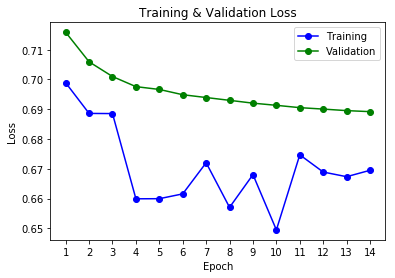

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (30,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 42 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (42, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.73
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.73
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.22
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 5 / 

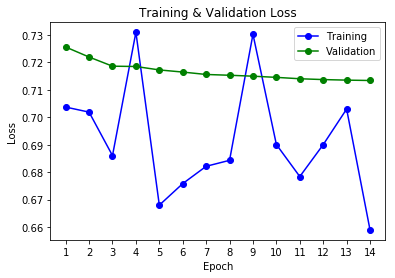

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.84      0.28      0.42       715
     class 1       0.19      0.76      0.31       163

    accuracy                           0.37       878
   macro avg       0.51      0.52      0.36       878
weighted avg       0.72      0.37      0.40       878

confusion matrix on test set is:



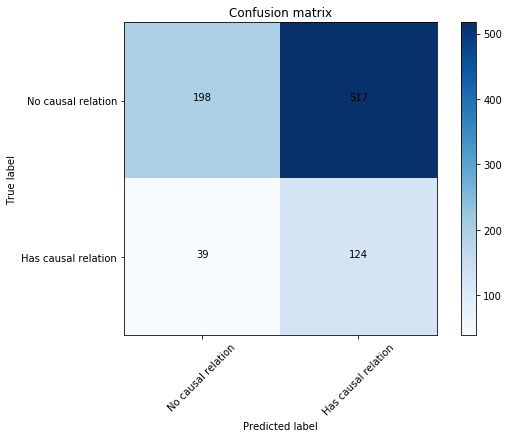

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (50,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 66 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (66, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.73
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.72
  Training epcoh took: 0:00:00

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 5 / 

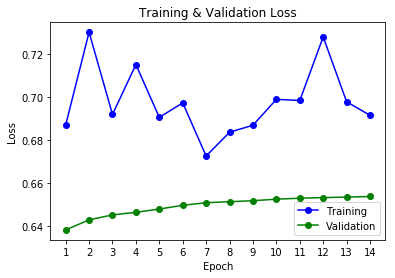

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (50,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 68 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (68, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.68
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.71
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.25
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 5 / 

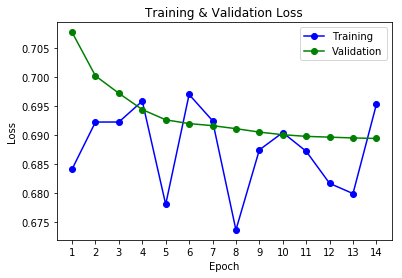

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (50,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 78 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (78, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.71
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.24
  Validation Loss: 0.72
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.24
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.29
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.47
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 5 / 

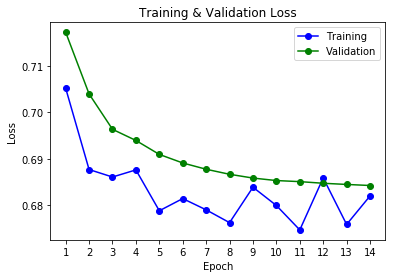

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (50,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 72 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (72, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.72
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 5 / 

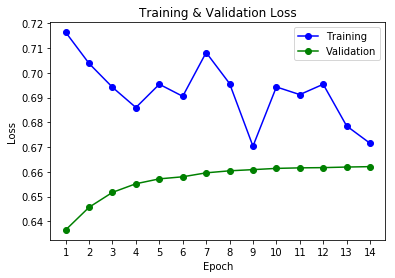

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (50,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 74 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (74, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.42
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.42
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.42
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.42
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 5 / 

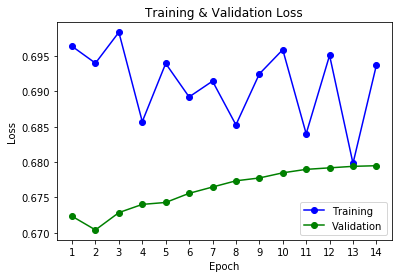

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.08      0.45      0.13        40
     class 1       0.97      0.74      0.84       838

    accuracy                           0.73       878
   macro avg       0.52      0.59      0.48       878
weighted avg       0.93      0.73      0.80       878

confusion matrix on test set is:



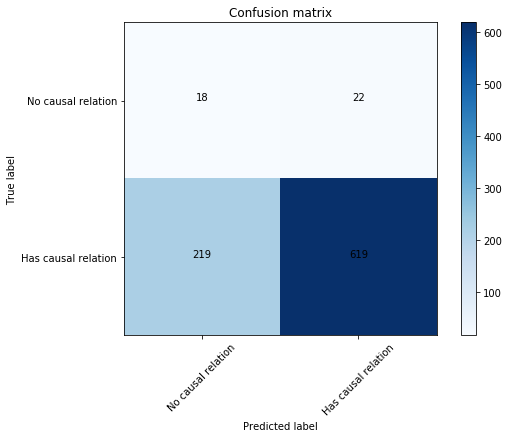

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (100,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 138 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (138, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.46
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.45
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.51
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.52
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 5 / 

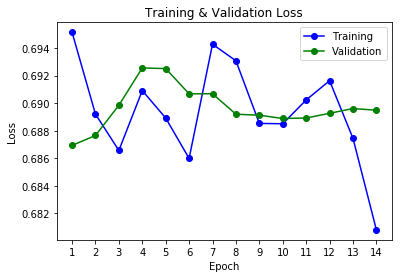

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (100,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 146 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (146, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.41
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 5 / 

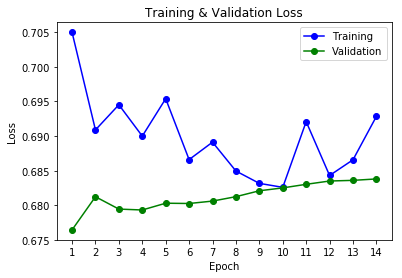

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (100,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 154 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (154, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.40
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 5 / 

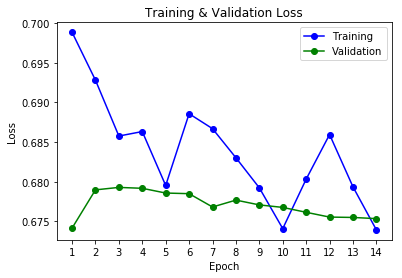

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (100,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 140 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (140, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.23
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.17
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.17
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.21
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 5 / 

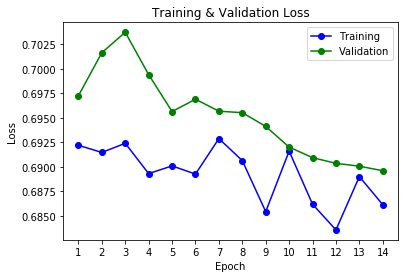

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (100,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 150 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (150, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.29
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.62
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:01

Running Validation...
  Macro F1 score: 0.54
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 5 / 

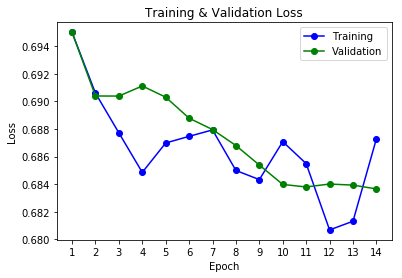

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.15      0.34      0.21       103
     class 1       0.89      0.74      0.81       775

    accuracy                           0.69       878
   macro avg       0.52      0.54      0.51       878
weighted avg       0.81      0.69      0.74       878

confusion matrix on test set is:



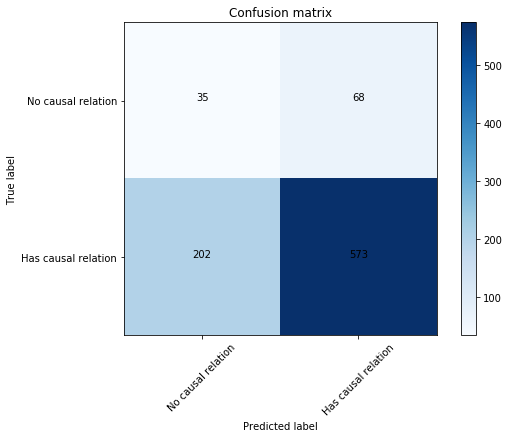

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (300,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 420 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (420, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.53
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.70
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.26
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 5 / 

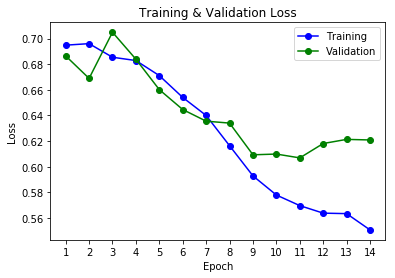

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (300,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 438 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (438, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.42
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.52
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.66
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 5 / 

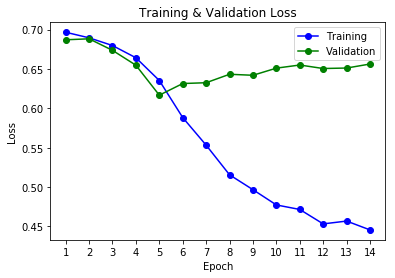

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (300,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 440 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (440, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.71
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.63
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.65
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.53
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.49
  Validation Loss: 0.63
  Validation took: 0:00:01

======== Epoch 5 / 

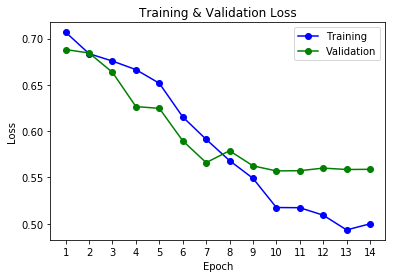

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (300,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 416 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (416, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 5 / 

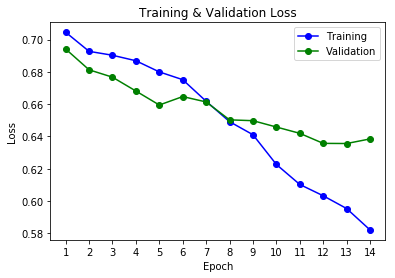

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (300,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 430 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (430, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.55
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.58
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.66
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:03

Running Validation...
  Macro F1 score: 0.71
  Validation Loss: 0.62
  Validation took: 0:00:01

======== Epoch 5 / 

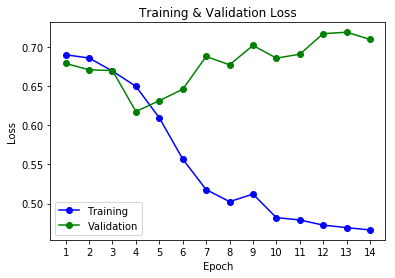

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.64      0.39      0.49       385
     class 1       0.63      0.83      0.72       493

    accuracy                           0.64       878
   macro avg       0.64      0.61      0.60       878
weighted avg       0.64      0.64      0.62       878

confusion matrix on test set is:



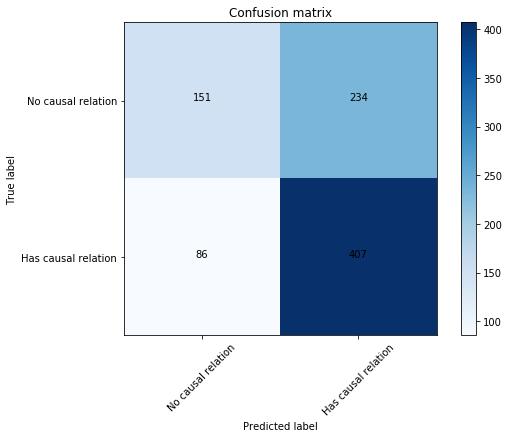

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (500,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 716 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (716, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:05

Running Validation...
  Macro F1 score: 0.55
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:05

Running Validation...
  Macro F1 score: 0.54
  Validation Loss: 0.57
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.63
  Training epcoh took: 0:00:05

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.58
  Training epcoh took: 0:00:05

Running Validation...
  Macro F1 score: 0.59
  Validation Loss: 0.59
  Validation took: 0:00:01

======== Epoch 5 / 

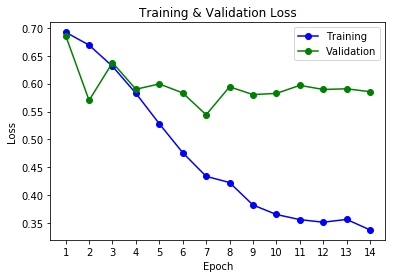

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (500,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 746 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (746, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.45
  Validation Loss: 0.63
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.66
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.59
  Validation Loss: 0.61
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.59
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.58
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.55
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.52
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 5 / 

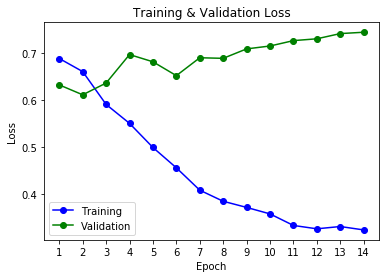

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (500,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 742 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (742, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.55
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.59
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.68
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.55
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.67
  Validation Loss: 0.53
  Validation took: 0:00:01

======== Epoch 5 / 

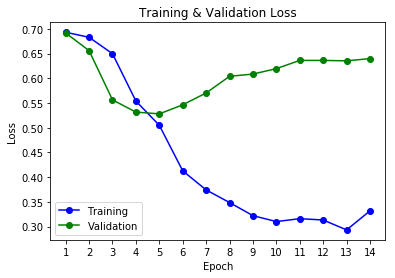

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (500,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 714 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (714, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.46
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.66
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.63
  Validation Loss: 0.63
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.59
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.47
  Validation Loss: 0.76
  Validation took: 0:00:01

======== Epoch 5 / 

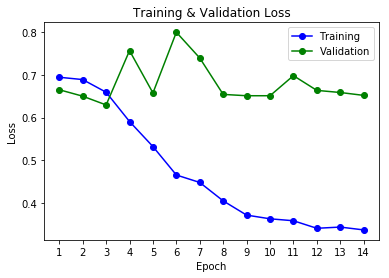

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (500,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 718 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (718, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.53
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
current lr is: 7.500000000000001e-06

  Average training loss: 0.69
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.61
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
current lr is: 5.625000000000001e-06

  Average training loss: 0.61
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.61
  Validation Loss: 0.61
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
current lr is: 4.218750000000001e-06

  Average training loss: 0.53
  Training epcoh took: 0:00:06

Running Validation...
  Macro F1 score: 0.57
  Validation Loss: 0.76
  Validation took: 0:00:01

======== Epoch 5 / 

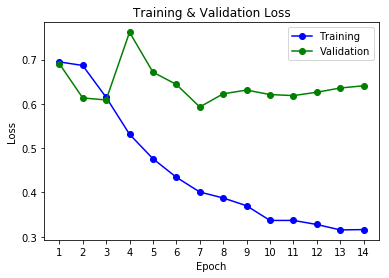

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.55      0.46      0.50       283
     class 1       0.76      0.82      0.79       595

    accuracy                           0.70       878
   macro avg       0.65      0.64      0.64       878
weighted avg       0.69      0.70      0.70       878

confusion matrix on test set is:



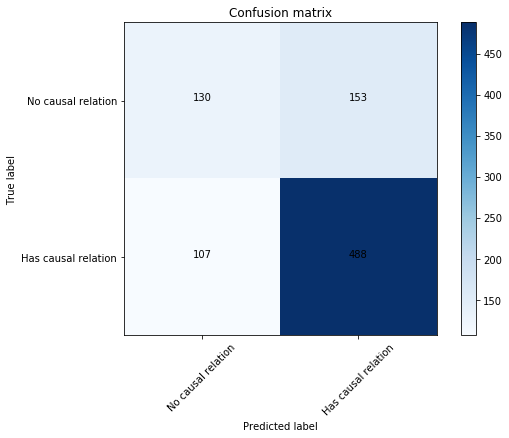

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (700,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1012 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1012, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.43
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.62
  Validation Loss: 0.59
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.60
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.66
  Validation Loss: 0.53
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 4.21875000000

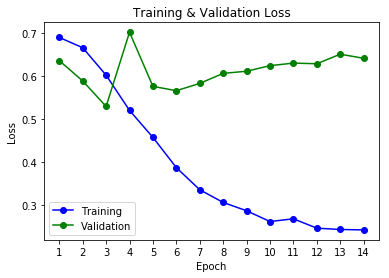

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (700,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1034 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1034, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.71
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.57
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.60
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.57
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.60
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 4.21875000000

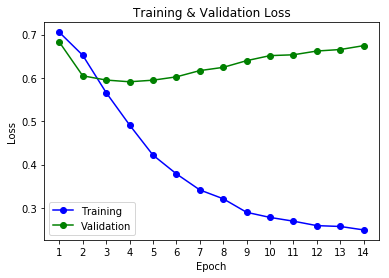

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (700,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1042 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1042, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.44
  Validation Loss: 0.66
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.67
  Validation Loss: 0.54
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.52
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.65
  Validation Loss: 0.53
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 4.21875000000

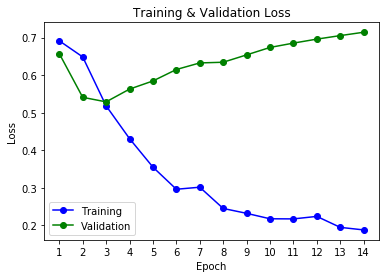

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (700,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1004 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1004, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.52
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.68
  Validation Loss: 0.54
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.55
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.64
  Validation Loss: 0.59
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 4.21875000000

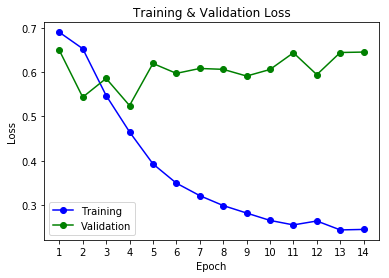

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (700,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1032 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1032, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.52
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.67
  Validation Loss: 0.54
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.57
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.69
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 4.21875000000

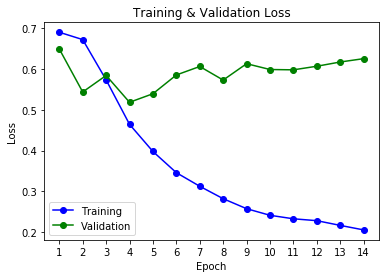

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.50      0.54      0.52       219
     class 1       0.84      0.82      0.83       659

    accuracy                           0.75       878
   macro avg       0.67      0.68      0.67       878
weighted avg       0.76      0.75      0.75       878

confusion matrix on test set is:



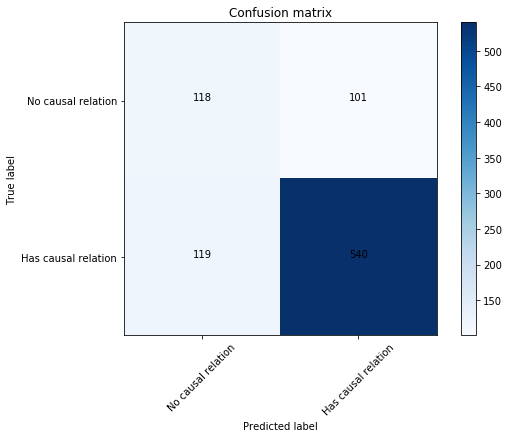

0 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (702,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1012 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1012, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.66
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.64
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.58
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.62
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 4.21875000000

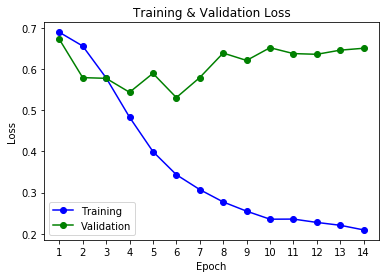

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (702,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1034 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1034, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.64
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.63
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.55
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.64
  Validation Loss: 0.55
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 4.21875000000

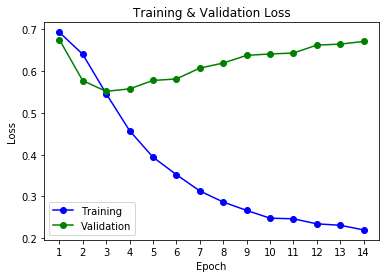

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (702,) (176,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1044 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1044, 2) (176, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.63
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.67
  Validation Loss: 0.54
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.51
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.71
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:06.
current lr is: 4.21875000000

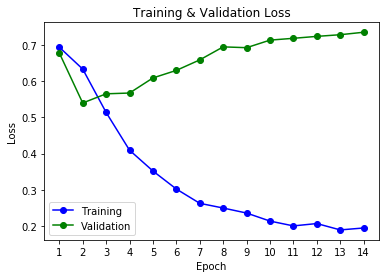

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (703,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1006 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1006, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.64
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.67
  Validation Loss: 0.59
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.56
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.61
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 4.21875000000

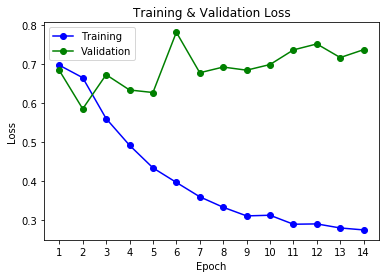

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
After selecting n_sample training data, now [X training set shape, X test set shape] is: (703,) (175,)
Now all training data is true class, we will not do oversampling for this turn.

We totally have 1032 training data after oversampling.
[X over-sampled training set shape, X over-sampled test set shape]: (1032, 2) (175, 2)

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.52
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.65
  Validation Loss: 0.60
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.52
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.72
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 4.21875000000

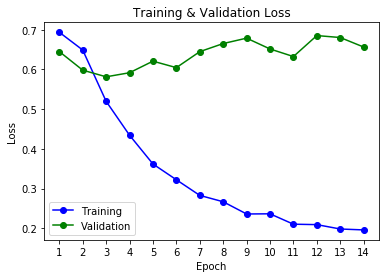

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.52      0.51      0.52       244
     class 1       0.81      0.82      0.82       634

    accuracy                           0.73       878
   macro avg       0.67      0.66      0.67       878
weighted avg       0.73      0.73      0.73       878

confusion matrix on test set is:



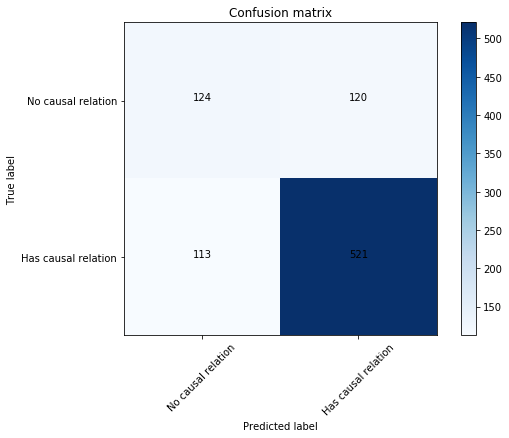

In [16]:
result_dict = sensitivity_analysis(X,y,best_args,n_samples)

## Visualize the result

In [20]:
key = result_dict.keys()
test_f1 = []
test_precision = []
test_recall = []


for i in key:
    test_precision.append(result_dict[i]['precision_test'])
    test_recall.append(result_dict[i]['recall_test'])
    test_f1.append(result_dict[i]['f1_test'])

Text(0, 0.5, 'evaluation metrics')

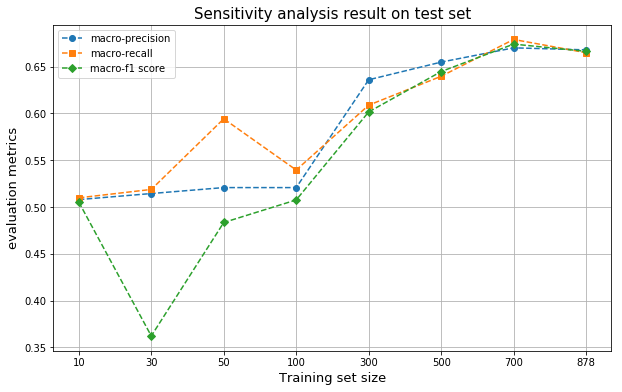

In [36]:
plt.figure(figsize=(10,6))

plt.title('Sensitivity analysis result on test set', fontsize=15)

values = range(len(key))

plt.plot(values,test_precision,'--',marker="o")
plt.plot(values,test_recall,'--',marker="s")
plt.plot(values,test_f1,'--',marker="D")
plt.grid(True)
plt.legend(['macro-precision','macro-recall','macro-f1 score'])
#plt.title.set_text('Sensitivity analysis result on test set')
plt.xticks(values,key)
plt.xlabel('Training set size', fontsize=13)
plt.ylabel('evaluation metrics', fontsize=13)

In general, As the size of the training set increases, our metrics increase generally.